## Marathi Interactive TTS notebooking using Tacotron 2 and Waveglow

This notebook is similiar to its Hindi counterpart and hence we skip the theory part for convenience. Run this notebook and change the input text to get the desired Marathi speech output. 

#### Step 1: Import libraries

In [1]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import sys
sys.path.append('waveglow/')
import numpy as np
import torch

from hparams import create_hparams
from model import Tacotron2
from layers import TacotronSTFT, STFT
from audio_processing import griffin_lim
from train import load_model
from text import text_to_sequence
from denoiser import Denoiser

C:\Users\vinee\OneDrive\Desktop\SLP\SSMT\tacotron2\plotting_utils.py:2: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "c:\users\vinee\anaconda3\envs\tensorflow_cs626\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "c:\users\vinee\anaconda3\envs\tensorflow_cs626\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "c:\users\vinee\anaconda3\envs\tensorflow_cs626\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "c:\users\vinee\anaconda3\envs\tensorflow_cs626\lib\site-packages\traitlets\config\application.py", line 664, in launch_instance
    app.start()
  File "c:\users\vinee\anaconda3\envs\tensorflow_cs6

#### Step 2: Define the plot function for melspectrograms and alignment function

In [2]:
def plot_data(data, figsize=(16, 4)):
    fig, axes = plt.subplots(1, len(data), figsize=figsize)
    for i in range(len(data)):
        axes[i].imshow(data[i], aspect='auto', origin='bottom', 
                       interpolation='none')

#### Step 3: Setting up the hyperparamaters and loading the checkpoint file

In [3]:
hparams = create_hparams()
hparams.sampling_rate = 22050


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [4]:
checkpoint_path = "C:\\Users\\vinee\\Downloads\\checkpoint_2600"
model = load_model(hparams)
model.load_state_dict(torch.load(checkpoint_path)['state_dict'])
_ = model.cuda().eval().half()

#### Step 4: Load WaveGlow for mel2audio synthesis and denoiser

In [5]:
waveglow_path = 'D:\\waveglow_256channels_universal_v5.pt'
waveglow = torch.load(waveglow_path)['model']
waveglow.cuda().eval().half()
for k in waveglow.convinv:
    k.float()
denoiser = Denoiser(waveglow)

c:\users\vinee\anaconda3\envs\tensorflow_cs626\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.ConvTranspose1d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\users\vinee\anaconda3\envs\tensorflow_cs626\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.container.ModuleList' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
c:\users\vinee\anaconda3\envs\tensorflow_cs626\lib\site-packages\torch\serialization.py:657: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv1d' has changed. you can r

#### Step 5: Prepare text input

In [6]:
#text = "मी बाजारात जातो" # I go to the market
text = "बुद्धिबळ हा भारतातील एक प्रसिद्ध खेळ आहे" # Chess is a famous sport in India
sequence = np.array(text_to_sequence(text, ['transliteration_cleaners']))[None, :]
sequence = torch.autograd.Variable(
    torch.from_numpy(sequence)).cuda().long()

#### Step 6: Decode text input and plot results

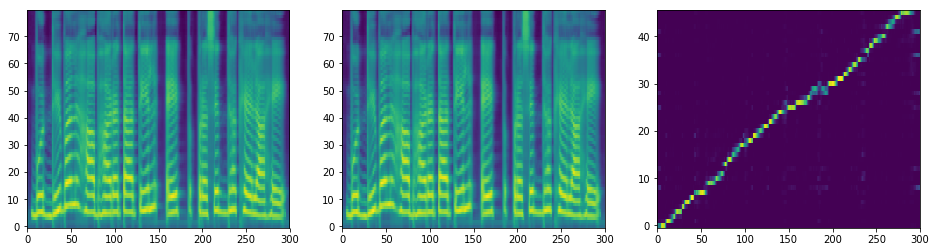

In [7]:
mel_outputs, mel_outputs_postnet, _, alignments = model.inference(sequence)
plot_data((mel_outputs.float().data.cpu().numpy()[0],
           mel_outputs_postnet.float().data.cpu().numpy()[0],
           alignments.float().data.cpu().numpy()[0].T))

#### Step 7: Synthesize audio from spectrogram using WaveGlow

In [8]:
with torch.no_grad():
    audio = waveglow.infer(mel_outputs_postnet, sigma=0.666)
ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate)

#### References

1. "Natural TTS Synthesis by Conditioning WaveNet on Mel Spectrogram Predictions" - Shen et al, ICASSP 2018

2. "WaveGlow: A Flow-based Generative Network for Speech Synthesis" - Prenger et al, ICASSP 2019

3. Indic TTS Databasee - IIT Madras : https://www.iitm.ac.in/donlab/tts/index.php

4. Blog on English TTS Using Tacotron 2 and WaveGlow by Nvidia: https://developer.nvidia.com/blog/generate-natural-sounding-speech-from-text-in-real-time/

5. Tacotron 2 Github: https://github.com/NVIDIA/tacotron2

6. WaveGlow Github: https://github.com/NVIDIA/waveglow